# Bound states in a continuum and Q-factors
In this example we apply `legume` to calculate bound states in a continuum in a PhC slab. This example is related to Sec. 4.1 of the CPC paper.


In [1]:
import legume
print(f"Version of the imported legume : {legume.__version__}")

import numpy as np
import matplotlib.pyplot as plt
import copy

Version of the imported legume : 1.0.0


## Define the PhC 

The PhC slab consists of a square lattice of period $a=400$ nm, hole radius $r=100$ nm, etched in a suspended slab of thickness $d=80$ nm with refractive index $n=3.45$. It is the same parameters of Fig. 8 of the CPC paper, but we use dimensionless units here.

In [2]:
D = 0.2 # slab thickness in units of a
r = 0.25  # hole radius in units of a
eps_c = 1          # permittivity of circular holes
eps_b = 3.45**2    # background permittivity of slab
eps_lower, eps_upper = 1, 1  # permittivities of lower and upper claddings

lattice = legume.Lattice('square')
phc = legume.PhotCryst(lattice, eps_l=eps_lower, eps_u=eps_upper)
phc.add_layer(d=D, eps_b=eps_b)
phc.layers[-1].add_shape(legume.Circle(eps=eps_c, r=r, x_cent=0., y_cent=0))

gme = legume.GuidedModeExp(phc, gmax=4.5, truncate_g='abs')
npw = np.shape(gme.gvec)[1]  # number of plane waves in the expansion
print('Number of reciprocal lattice vectors in the expansion: npw = ', npw)

Number of reciprocal lattice vectors in the expansion: npw =  69


In [3]:
# Run the guided-mode expansion
numeig, verbose = 20, True
nk = 20
path = lattice.bz_path(['X', 'G', 'M'], [nk])

gme.run(kpoints=path['kpoints'], gmode_inds=[0, 1, 2, 3], numeig=numeig, verbose=True)
freqs = gme.freqs

nkappa, nfreq = freqs.shape[0], freqs.shape[1]
print(f'Number of wavevectros = {nkappa}, number of frequencies = {nfreq}')

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 69 plane waves and 4 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'       │ 1.641    │ │████████████--------│   63% │
│ Inverse matrix of Fourier-space permittivity              │ 0.002    │ │--------------------│    0% │
│ Matrix diagionalization using the 'eigh' solver           │ 0.181    │ │█-------------------│    7% │
│ Creating GME matrix                                       │ 0.756    │ │█████---------------│   29% │
├───────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 41 k-points   │ 2.601    │ │████████████████████│  100% │
└───────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 69 plane waves and 4 guided modes       ┃ Time (s) ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Total time for imaginary part of frequencies for 820 eigenmodes │ 3.580    │
└─────────────────────────────────────────────────────────────────┴──────────┘

Number of wavevectros = 41, number of frequencies = 20


Plot the photonic bands and Q-factors

In the **legume** 1.0.0 version, `viz.bands` plots the frequencies as a function of wavevector along the path in the Brillouin zone by means of the kw argument `k_units=True`, which requires setting the xticks with `path['k_indexes']`.

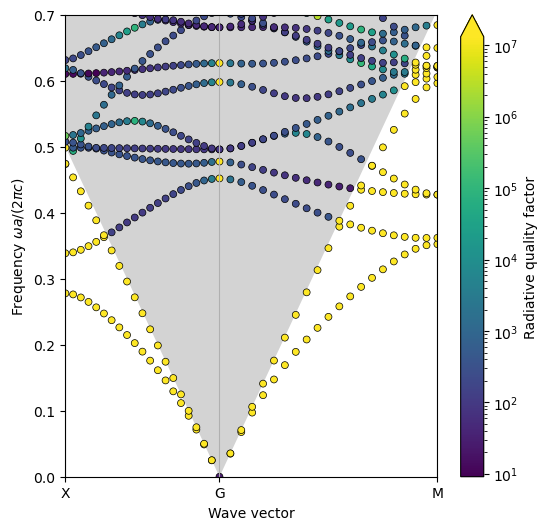

In [4]:
def plot_bands(gme):
    fig, ax = plt.subplots(1, figsize = (6, 6))
    legume.viz.bands(gme, Q=True, ax=ax, cone=True, k_units=True, conecolor='lightgrey',
                     markersize=5, markeredgecolor='black', markeredgewidth=0.5)
    ax.set_xticks(path['k_indexes'])
    ax.set_xticklabels(path['labels'])
    ax.xaxis.grid('True')
    ax.set_ylim([0., 0.7])

plot_bands(gme)

## Study of a symmetry-proteceted BIC

We see that there are several states at ${\bf k}=0$ with $Q\rightarrow\infty$, which are symmetry-protected BICs. In the square lattice, all nondegenerate states at the $\Gamma$ point are symmetry-protected BICs, and vice-versa (while the hexagonal lattice supports twofold degenerate BICs: see example 08).

Here we focus on the lowest BIC with a dimensionless frequency around 0.45, which is called BIC1 in Fig. 8(a) of the CPC paper. Let's plot the Q-factor close to ${\bf k}=0$: for this, however, we need a denser set of ${\bf k}$-points and we focus on a region closer to the $\Gamma$ point. We define the points $X_1=[0.1\pi,0]$ and $M_1=[0.1\pi,0.1\pi]$ and we calculate for wavevectors in the path $X_1\to\Gamma\to M_1$.

In [5]:
# Run the guided-mode expansion
numeig, verbose = 20, True
nk = 50

X1 = [0.1*np.pi, 0]
M1 = [0.1*np.pi, 0.1*np.pi]
path = lattice.bz_path([X1, 'G', M1], [nk])

gme = legume.GuidedModeExp(phc, gmax=4.5, truncate_g='abs')
gme.run(kpoints=path['kpoints'], gmode_inds=[0, 1, 2, 3], numeig=numeig, verbose=True)
freqs = gme.freqs
freqs_im = gme.freqs_im
nkappa, nfreq = freqs.shape[0], freqs.shape[1]
print(f'Number of wavevectors = {nkappa}, number of frequencies = {nfreq}')

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 69 plane waves and 4 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'       │ 4.670    │ │█████████████-------│   66% │
│ Inverse matrix of Fourier-space permittivity              │ 0.001    │ │--------------------│    0% │
│ Matrix diagionalization using the 'eigh' solver           │ 0.442    │ │█-------------------│    6% │
│ Creating GME matrix                                       │ 1.925    │ │█████---------------│   27% │
├───────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 101 k-points  │ 7.085    │ │████████████████████│  100% │
└───────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 69 plane waves and 4 guided modes        ┃ Time (s) ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Total time for imaginary part of frequencies for 2020 eigenmodes │ 8.673    │
└──────────────────────────────────────────────────────────────────┴──────────┘

Number of wavevectors = 101, number of frequencies = 20


We now want to plot the Q-factor versus the wavevector for the chosen mode, which has index jmode=2.

But there is an annoying issue we should fix: unfortunately the photonic bands are discontinuous at ${\bf k}=0$, as the code calculates one less frequency there.

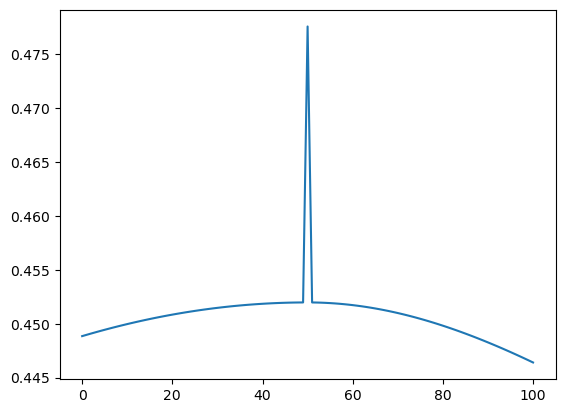

In [6]:
jmode = 2
plt.plot(range(nkappa), freqs[:,jmode])

Thus, we first make the frequencies and imaginary parts to be continuous, then we calculate and plot the Q-factor of the chosen mode. Compare with Fig. 9 of the CPC paper.

Text(0, 0.5, 'Q factor')

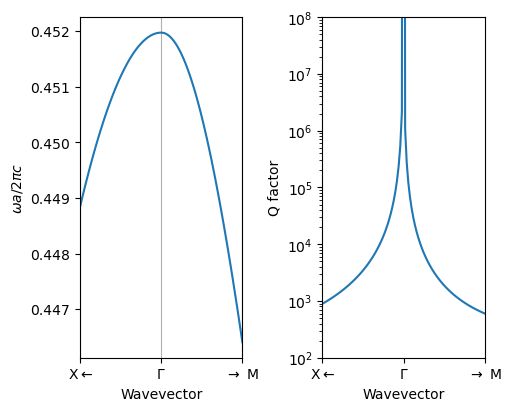

In [7]:
# shift the frequencies at k=0 to make them continuous
freqs_cured    = copy.deepcopy(freqs)
freqs_im_cured = copy.deepcopy(freqs_im)
freqs_cured[nk, 0] = 0
for j in range(1, nfreq-1):
  freqs_cured   [nk,j] = freqs   [nk, j-1]
  freqs_im_cured[nk,j] = freqs_im[nk, j-1]

# then we calculate and plot the Q-factor of that mode
jmode=2
qfactor = freqs_cured[:,jmode]/2/freqs_im_cured[:,jmode]
kappa = range(nkappa)

xticks, xticklabels = path['indexes'], [r'X$\leftarrow$', '$\Gamma$', r'$\rightarrow$ M']
markersize = 3

fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(5, 4))
for a in ax:
  a.set_xlim([0, gme.freqs.shape[0]-1])
  a.set_xlabel("Wavevector")
  a.set_xticks(path['indexes'])
  a.set_xticklabels(xticklabels)

ax[0].plot(kappa, freqs_cured[:, jmode])
ax[0].set_ylabel("$\omega a/2\pi c$")
ax[0].xaxis.grid('True')

ax[1].plot(kappa, qfactor)
ax[1].set_yscale('log')
ax[1].set_ylim([10**2, 10**8])
ax[1].set_ylabel("Q factor")

The Q-factor actually diverges as $Q\propto k^{-2}$ for ${\bf k}\rightarrow0$. This can be seen by using a double-log scale (see CPC paper, Fig. 9(b), inset) or by plotting the imaginary part of the frequency as a function of $k$. Compare also with Fig. S3 of [Zagaglia et el, Opt. Lett. 48, 5017 (2023)](https://doi.org/10.1364/OL.501595).

Text(0, 0.5, '$\\mathcal{I}(\\omega a/2\\pi c)$')

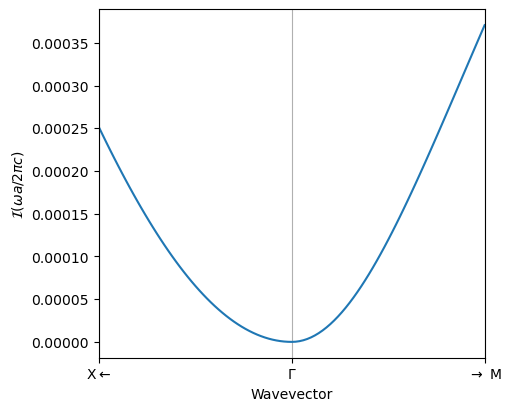

In [8]:
markersize = 1

fig, ax = plt.subplots(1, constrained_layout=True, figsize=(5, 4))
ax.plot(kappa, freqs_im_cured[:,2], markersize=markersize)
ax.set_xticks(path['indexes'])
ax.set_xticklabels(xticklabels)
ax.xaxis.grid('True')

#ax.set_yscale('log')
#ax.set_ylim([10**2, 10**8])
ax.set_xlim([0, gme.freqs.shape[0]-1])
ax.set_xlabel("Wavevector")
ax.set_ylabel("$\mathcal{I}(\omega a/2\pi c)$")

We see that there are many BICs with infinite Q-factor at $k=0$, which are BICs. (For symmetry reasons, in the square lattice with circular holes, all nondegenerate states are symmetry-protected BICs, and vice-versa).

Here we focus on the lowest BIC with dimensionless frequency around 0.45. Let's visualize the field components on the top of the slab (z=D). [The lowest cladding in legume extends from $z=-\infty$ to $z=0$.]

Target mode at band index 1 has frequency = 0.451974


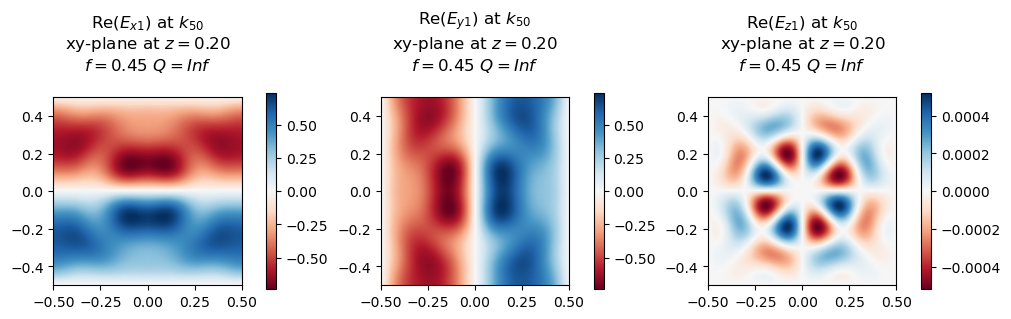

<Figure size 3200x400 with 0 Axes>

In [9]:
# to avoid the issue of the band discontinuity, for a given k we find the index j that correspond to the target mode
jk = nk
result = [(j, freqs[jk,j]) for j in range(nfreq) if ((freqs[jk,j] > 0.44) and (freqs[jk,j] < 0.46)) ]
(jmode, frequency) = result[0]
plt.rcParams['figure.figsize'] = [10,4] # We change the defualt figure size to better show field profiles
print(f"Target mode at band index {jmode} has frequency = {frequency:.6f}")

ax=legume.viz.field(gme, 'E', nk, jmode, z=D, component='xyz', val='re', N1=200, N2=200)
plt.figure().set_figwidth(32)
# be careful about real and imaginary parts... usually both of them can be nonzero
# in this particular case, the electric field is real, while the magnetic field is imaginary

<Figure size 1500x300 with 0 Axes>

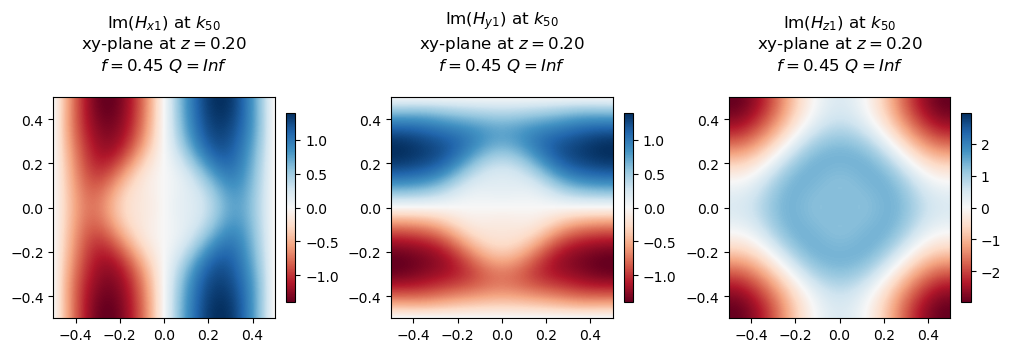

In [10]:
plt.figure(figsize=(15,3))
ax2=legume.viz.field(gme, 'H', nk, jmode, z=D, component='xyz', val='im', N1=200, N2=200)

See Appendix B of the CPC paper for a symmetry analysis of the BIC field profiles. This figure more or less corresponds to Fig. B.15 (which has a more sophisticated graphics).